In [ ]:
import glob
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import tqdm
import rasterio
from affine import Affine


In [ ]:
path=r"C:\Users\ASUS\Downloads\MODELO 3D IXTAPAN ESTE"
filenames=glob.glob(path+"/*/f*.obj")

In [ ]:
def map_d(x, in_min, in_max, out_min, out_max):
    """Genera una interpolacion para pasar de un rango a otro"""
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [ ]:
X=[]
Y=[]
Z=[]
res=[]
for file in tqdm.tqdm(filenames):
    with open(file,"r") as f:
        lines=f.readlines()
    for line in lines:
        if line[:2]=="v ":
            res.append(line.split()+list([file]))

In [ ]:
filenames

In [ ]:
df_coords=pd.DataFrame(res)
df_coords[3]=df_coords[3].astype("float64")
df_coords[1]=df_coords[1].astype("float64")
df_coords[2]=df_coords[2].astype("float64")
df_coords=df_coords.sort_values(by=[3]).reset_index(drop=True)

In [ ]:
df_coords=df_coords.drop_duplicates(subset=[1,2,3]).reset_index(drop=True)
df_coords=df_coords.astype({1:"int",2:int,3:int})
df_coords

In [ ]:
df_coords[1]=df_coords[1]-np.min(df_coords[1])
df_coords[2]=df_coords[2]-np.min(df_coords[2])

In [ ]:
new_image_width = int(np.max(df_coords[1]))+1
new_image_height = int(np.max(df_coords[2]))+1
new_image_height,new_image_width

In [ ]:
np.min(df_coords[2])

In [ ]:
with open(path+"/doc.kml","r") as kml:
    li=kml.readlines()
lineas_utiles=[]
for l in li:
    l=l.replace("\n","")
    lineas_utiles.append(l)
    if l.find("href")>=0:
        break
    elif l.find("minAltitude")>=0:
        minAltitude=float(l.split(">")[1].split("<")[0])
    elif l.find("maxAltitude")>=0:
        maxAltitude=float(l.split(">")[1].split("<")[0])
    elif l.find("west")>=0:
        west=float(l.split(">")[1].split("<")[0])
    elif l.find("east")>=0:
        east=float(l.split(">")[1].split("<")[0])
    elif l.find("north")>=0:
        north=float(l.split(">")[1].split("<")[0])
    elif l.find("south")>=0:
        south=float(l.split(">")[1].split("<")[0])
lineas_utiles
north,south,west,east,minAltitude,maxAltitude

In [ ]:
min_h=df_coords[3].min()
max_h=df_coords[3].max()
df_coords["Z"]=df_coords[3].apply(lambda x: map_d(x,min_h,max_h,minAltitude,maxAltitude))
min_h2=df_coords[3].min()
df_coords

In [ ]:
min_h2=df_coords["Z"].min()
min_h2

In [ ]:
color = (0)
result = np.full((new_image_height,new_image_width), color, dtype="float32")
for i in tqdm.tqdm(range(len(df_coords))):
    result[df_coords.loc[i,2],df_coords.loc[i,1]]=df_coords.loc[i,"Z"]
    

In [ ]:
# result=result[400:500,800:900,0]
for i in range(10):
    result[result==0]=result[tuple([x-1 for x in np.where(result==0)])]

In [ ]:
punto_1=gpd.GeoSeries(Point([west,north]),crs=6364)
punto_2=gpd.GeoSeries(Point([east,south]),crs=6364)
longitud1,latitud1=str(punto_1.to_crs(3857)).split("(")[1].split(")")[0].split()
longitud2,latitud2=str(punto_2.to_crs(3857)).split("(")[1].split(")")[0].split()
longitud1,latitud1,longitud2,latitud2=np.array([longitud1,latitud1,longitud2,latitud2],dtype="float32")
longitud1,latitud1,longitud2,latitud2

In [ ]:
metrosxpixelx=result.shape[1]/(longitud2-longitud1)
metrosxpixely=result.shape[0]/(latitud2-latitud1)
metrosxpixelx,metrosxpixely

In [ ]:
(longitud2-longitud1)/result.shape[1]

In [ ]:
0.98  1.02

In [ ]:
punto_max=gpd.GeoSeries(Point([west,north]),crs=6364)
longitud,latitud=str(punto_max.to_crs(3857)).split("(")[1].split(")")[0].split()
longitud=float(longitud)#-np.min(df_coords[1])
latitud=float(latitud)#-np.min(df_coords[2])
metrosxpixelx=result.shape[1]/(longitud2-longitud1) ##siempre positivo
metrosxpixely=result.shape[0]/(latitud2-latitud1)  ##siempre negativo
crs=3857
matriz=np.flip(result,0)


transform=Affine(metrosxpixelx,0,longitud,0,metrosxpixely,latitud) 
out_meta=({"driver": "GTiff",
            "height": matriz.shape[0],
            "width": matriz.shape[1],
            "count":1,
            "dtype":np.float32,
            "crs":crs,
            "nodata":0,
          'transform':transform})
with rasterio.open(r"C:\Users\ASUS\Downloads\MODELO 3D IXTAPAN ESTE/este_ixtapan.tif",'w', **out_meta) as dest_file:
    dest_file.write(matriz, 1)

In [ ]:
breakpoint

In [2]:
import rasterio
src=rasterio.open(r"C:\Users\ASUS\Downloads\MODELO 3D IXTAPAN ESTE/este_ixtapan.tif")

In [9]:
src1=rasterio.open(r"C:\Users\ASUS\Downloads\MODELO 3D IXTAPAN ESTE/este_ixtapan.tif")

In [3]:
s=src.read()
s=s[0]

In [10]:
s1=src1.read()
s1=s1[0]

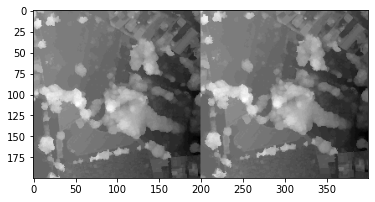

In [19]:
y=100
x=100
a=s[y:y+200,x:x+200]
a1=s[y+5:y+5+200,x+1:x+1+200]
a=a-np.min(a)
a1=a1-np.min(a1)
plt.imshow(np.hstack([a,a1]),cmap="gray")
plt.show()

(125, 150)

In [14]:
a.max()

21.0

In [ ]:
1/.98